In [1]:
from ema_workbench import load_results
import pandas as pd
import statsmodels.api as sm
from ema_workbench.analysis import prim
from ema_workbench import ema_logging
import numpy as np
desired_width = 320
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',50)
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from dike_model_simulation import problem_formulation
from SALib.analyze import sobol
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
dike_model, planning_steps = get_model_for_problem_formulation(problem_formulation)

C:\Users\lvanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)


In [2]:
def setup_dataframe_outcomes (outcomes):
    outcome = {f'{key} {i + 1}': value[:, i] for key, value in outcomes.items() for i in range(value.shape[1])}
    df_outcomes = pd.DataFrame(outcome)
    for i in range(1,6):
        df_outcomes[f'A.{i}_Expected_Anual_Dagame'] = (df_outcomes[[col for col in df_outcomes.columns if col.startswith(f'A.{i}_Expected Annual Damage')]].sum(axis=1))*(200/len(planning_steps))
        df_outcomes = df_outcomes.drop(df_outcomes.columns[df_outcomes.columns.str.startswith(f'A.{i}_Expected Annual Damage')], axis=1)

        df_outcomes[f'A.{i}_Dike_Investment_Costs'] = df_outcomes[[col for col in df_outcomes.columns if col.startswith(f'A.{i}_Dike Investment Costs')]].sum(axis=1)
        df_outcomes = df_outcomes.drop(df_outcomes.columns[df_outcomes.columns.str.startswith(f'A.{i}_Dike Investment Costs')], axis=1)

        df_outcomes[f'A.{i}_Expected_Number_of_Deaths'] = df_outcomes[[col for col in df_outcomes.columns if col.startswith(f'A.{i}_Expected Number of Deaths')]].sum(axis=1)*(200/len(planning_steps))
        df_outcomes = df_outcomes.drop(df_outcomes.columns[df_outcomes.columns.str.startswith(f'A.{i}_Expected Number of Deaths')], axis=1)

    df_outcomes['RfR_Total_Costs'] = df_outcomes[[col for col in df_outcomes.columns if col.startswith('RfR Total Costs')]].sum(axis=1)
    df_outcomes = df_outcomes.drop(df_outcomes.columns[df_outcomes.columns.str.startswith('RfR Total Costs')], axis=1)

    df_outcomes['Expected_evacuation_costs'] = df_outcomes[[col for col in df_outcomes.columns if col.startswith('Expected Evacuation Costs')]].sum(axis=1)
    df_outcomes = df_outcomes.drop(df_outcomes.columns[df_outcomes.columns.str.startswith('Expected Evacuation Costs')], axis=1)

    df_outcomes['Total_Expected_Number_of_Deaths'] = df_outcomes[[col for col in df_outcomes.columns if col.endswith('Expected_Number_of_Deaths')]].sum(axis=1)
    df_outcomes['Total_Dike_Investment_Costs'] = df_outcomes[[col for col in df_outcomes.columns if col.endswith('Dike_Investment_Costs')]].sum(axis=1)
    df_outcomes['Total_Expected_Anual_Dagame'] = df_outcomes[[col for col in df_outcomes.columns if col.endswith('Expected_Anual_Dagame')]].sum(axis=1)
    return df_outcomes

In [3]:
def run_regression (kpi, df_outcomes, df_experiments, name):
    final_lhs = df_outcomes[kpi]
    X_0 = sm.add_constant(df_experiments)
    est = sm.OLS(final_lhs, X_0.astype(float)).fit()
    parameters_df = pd.DataFrame(est.params, columns=['Parameter'])
    parameters_df.index.name = 'Variable'
    # Save parameters to CSV
    parameters_df.to_csv(f'./results/{name}/parameters_{kpi}.csv')
    # Save summary to CSV
    with open(f'./results/{name}/summary_{kpi}.txt', 'w') as f:
        f.write(est.summary().as_text())

#### 2. Sobol

In [4]:
def run_sobol(df_outcomes_sobol, kpi, problem, name):
    final_sobol = df_outcomes_sobol[kpi].to_numpy()
    Si = sobol.analyze(problem, final_sobol, calc_second_order=True, print_to_console=True)
    Si_filter = {k: Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])

    try:
        sns.set_style('white')
        fig, ax = plt.subplots(1)

        indices = Si_df[['S1', 'ST']]
        err = Si_df[['S1_conf', 'ST_conf']]

        indices.plot.bar(yerr=err.values.T, ax=ax)
        fig.set_size_inches(8, 6)
        fig.subplots_adjust(bottom=0.3)

        # Create the directory if it doesn't exist
        os.makedirs(f'./results/{name}', exist_ok=True)

        plt.savefig(f'./results/{name}/sobol_plot_{kpi}.png')

        plt.close(fig)  # Close the figure to free up resources
    except Exception as e:
        print(f"An error occurred while creating the plot: {str(e)}")
        # Perform any desired actions when the plot cannot be created
        # For example, return an empty plot, log the error, or continue with other code


In [5]:
def check_convergence (df_outcomes_sobol, kpi, problem, name):
    Y = df_outcomes_sobol[kpi].to_numpy()
    s_data = pd.DataFrame(index=problem['names'],
                          columns=np.arange(20,100,50)*(2*problem['num_vars']+2))
    for j in s_data.columns:
        scores = sobol.analyze(problem, Y[0:j], calc_second_order=True, print_to_console=False)
        s_data.loc[:,j] = scores['ST']
    fig, ax = plt.subplots(1)

    s_data.T.plot(ax=ax)
    ax.set_xlabel('Samples')
    ax.set_ylabel('Total index (ST)')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
    plt.savefig(f'./results/{name}/scenario_check_plot_{kpi}.png')

In [6]:
def run_sensitivity_analysis(sobol, regular, name):
    if not os.path.exists(f'./results/{name}'):
        os.mkdir(f'./results/{name}')
    else:
        for filename in os.listdir(f'./results/{name}'):
            file_path = os.path.join(f'./results/{name}', filename)
            if os.path.isfile(file_path):
                os.remove(file_path)
        # shutil.rmtree(f'./results/{name}')
        # os.mkdir(f'./results/{name}')
    experiments, outcomes = load_results(regular)
    experiments_sobol, outcomes_sobol = load_results(sobol)
    df_outcomes = setup_dataframe_outcomes(outcomes)
    df_outcomes_sobol = setup_dataframe_outcomes(outcomes_sobol)

    df_experiments = experiments.drop(['policy', 'model', 'scenario'], axis = 1)
    df_experiments_sobol = experiments_sobol.drop(['policy', 'model', 'scenario'], axis = 1)
    run_regression ('Total_Expected_Number_of_Deaths', df_outcomes, df_experiments, name)
    run_regression ('Total_Dike_Investment_Costs', df_outcomes, df_experiments, name)
    run_regression ('Total_Expected_Anual_Dagame', df_outcomes, df_experiments, name)
    run_regression ('Expected_evacuation_costs', df_outcomes, df_experiments, name)
    run_regression ('RfR_Total_Costs', df_outcomes, df_experiments, name)

    problem = get_SALib_problem(dike_model.uncertainties)

    run_sobol (df_outcomes_sobol, 'Total_Expected_Number_of_Deaths', problem, name)
    run_sobol (df_outcomes_sobol, 'Total_Dike_Investment_Costs', problem, name)
    run_sobol (df_outcomes_sobol, 'Total_Expected_Anual_Dagame', problem, name)
    run_sobol (df_outcomes_sobol, 'Expected_evacuation_costs', problem, name)
    run_sobol (df_outcomes_sobol, 'RfR_Total_Costs', problem, name)

    check_convergence (df_outcomes_sobol, 'Total_Expected_Number_of_Deaths', problem, name)
    check_convergence (df_outcomes_sobol, 'Total_Dike_Investment_Costs', problem, name)
    check_convergence (df_outcomes_sobol, 'Total_Expected_Anual_Dagame', problem, name)
    check_convergence (df_outcomes_sobol, 'Expected_evacuation_costs', problem, name)
    check_convergence (df_outcomes_sobol, 'RfR_Total_Costs', problem, name)

C:\Users\lvanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\lvanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1870: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
C:\Users\lvanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\lvanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
C:\Users\lvanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression

                                   ST   ST_conf
A.0_ID flood wave shape  8.358499e-03  0.003780
A.1_Bmax                 2.836913e-02  0.016898
A.1_Brate                1.847583e-04  0.000181
A.1_pfail                2.775689e-01  0.045480
A.2_Bmax                 3.044715e-03  0.004720
A.2_Brate                1.618513e-05  0.000018
A.2_pfail                2.643895e-02  0.011834
A.3_Bmax                 9.589437e-05  0.000101
A.3_Brate                1.206793e-05  0.000015
A.3_pfail                7.203475e-01  0.097440
A.4_Bmax                 7.255290e-06  0.000012
A.4_Brate                7.205796e-07  0.000002
A.4_pfail                1.840275e-03  0.001151
A.5_Bmax                 0.000000e+00  0.000000
A.5_Brate                0.000000e+00  0.000000
A.5_pfail                1.700907e-02  0.004994
discount rate 0          0.000000e+00  0.000000
discount rate 1          0.000000e+00  0.000000
discount rate 2          0.000000e+00  0.000000
discount rate 3          0.000000e+00  0

C:\Users\lvanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\SALib\analyze\sobol.py:129: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


                         ST  ST_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A.2_pfail               NaN      NaN
A.3_Bmax                NaN      NaN
A.3_Brate               NaN      NaN
A.3_pfail               NaN      NaN
A.4_Bmax                NaN      NaN
A.4_Brate               NaN      NaN
A.4_pfail               NaN      NaN
A.5_Bmax                NaN      NaN
A.5_Brate               NaN      NaN
A.5_pfail               NaN      NaN
discount rate 0         NaN      NaN
discount rate 1         NaN      NaN
discount rate 2         NaN      NaN
discount rate 3         NaN      NaN
                         S1  S1_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A

C:\Users\lvanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\SALib\analyze\sobol.py:129: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


                         ST  ST_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A.2_pfail               NaN      NaN
A.3_Bmax                NaN      NaN
A.3_Brate               NaN      NaN
A.3_pfail               NaN      NaN
A.4_Bmax                NaN      NaN
A.4_Brate               NaN      NaN
A.4_pfail               NaN      NaN
A.5_Bmax                NaN      NaN
A.5_Brate               NaN      NaN
A.5_pfail               NaN      NaN
discount rate 0         NaN      NaN
discount rate 1         NaN      NaN
discount rate 2         NaN      NaN
discount rate 3         NaN      NaN
                         S1  S1_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A

C:\Users\lvanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\SALib\analyze\sobol.py:129: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


                         ST  ST_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A.2_pfail               NaN      NaN
A.3_Bmax                NaN      NaN
A.3_Brate               NaN      NaN
A.3_pfail               NaN      NaN
A.4_Bmax                NaN      NaN
A.4_Brate               NaN      NaN
A.4_pfail               NaN      NaN
A.5_Bmax                NaN      NaN
A.5_Brate               NaN      NaN
A.5_pfail               NaN      NaN
discount rate 0         NaN      NaN
discount rate 1         NaN      NaN
discount rate 2         NaN      NaN
discount rate 3         NaN      NaN
                         S1  S1_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A

C:\Users\lvanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\SALib\analyze\sobol.py:129: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()
C:\Users\lvanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\SALib\analyze\sobol.py:129: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()
C:\Users\lvanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\SALib\analyze\sobol.py:129: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


                                   ST       ST_conf
A.0_ID flood wave shape  6.819907e-03  5.495812e-03
A.1_Bmax                 9.225892e-08  2.416331e-07
A.1_Brate                3.709877e-10  8.521922e-10
A.1_pfail                2.161233e-02  2.909918e-02
A.2_Bmax                 9.340064e-06  1.632393e-05
A.2_Brate                6.819512e-07  9.853420e-07
A.2_pfail                7.876218e-03  6.233474e-03
A.3_Bmax                 1.430490e-05  2.379277e-05
A.3_Brate                3.033580e-06  8.153843e-06
A.3_pfail                8.641480e-01  1.223769e-01
A.4_Bmax                 4.081256e-07  7.719093e-07
A.4_Brate                4.447494e-09  8.340120e-09
A.4_pfail                1.295854e-03  1.130273e-03
A.5_Bmax                 0.000000e+00  0.000000e+00
A.5_Brate                0.000000e+00  0.000000e+00
A.5_pfail                8.626562e-02  6.695387e-02
discount rate 0          0.000000e+00  0.000000e+00
discount rate 1          0.000000e+00  0.000000e+00
discount rat

C:\Users\lvanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\SALib\analyze\sobol.py:204: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
C:\Users\lvanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\SALib\analyze\sobol.py:217: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
C:\Users\lvanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\SALib\analyze\sobol.py:227: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
C:\Users\lvanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\lvanv\AppData\Local\Program

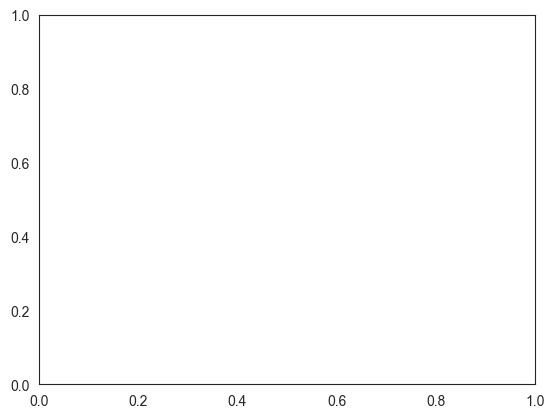

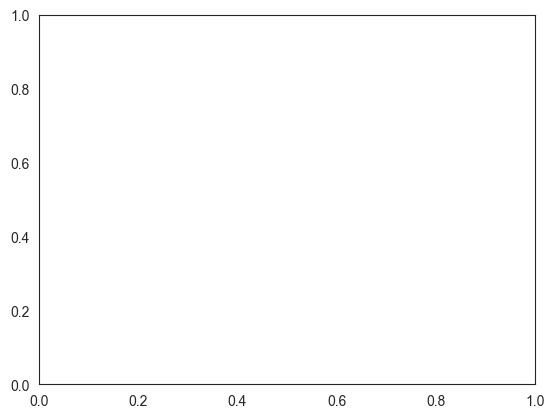

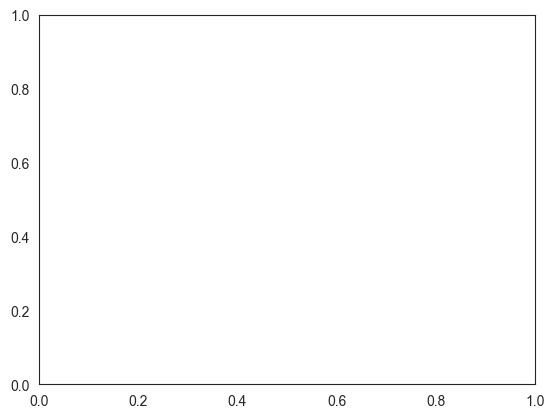

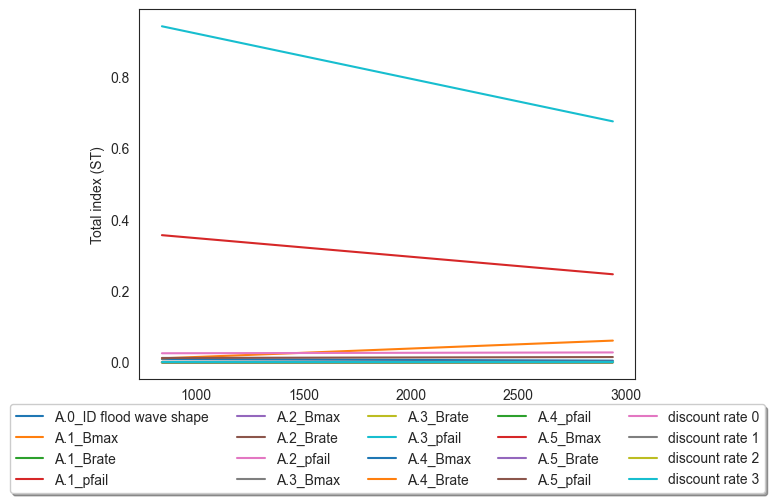

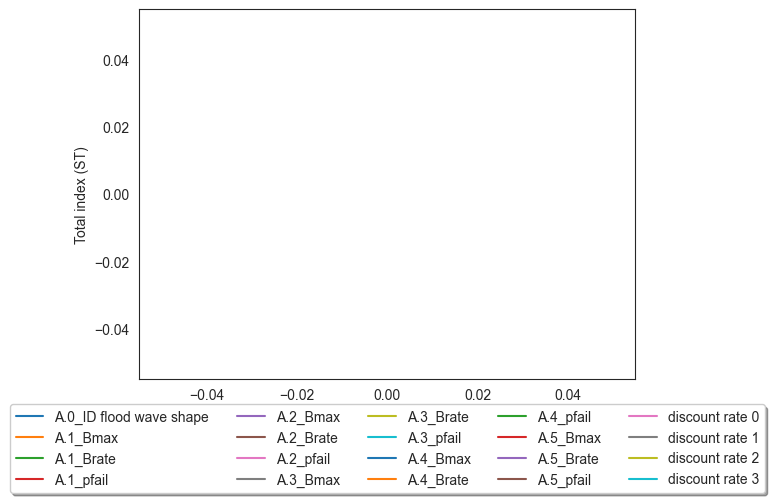

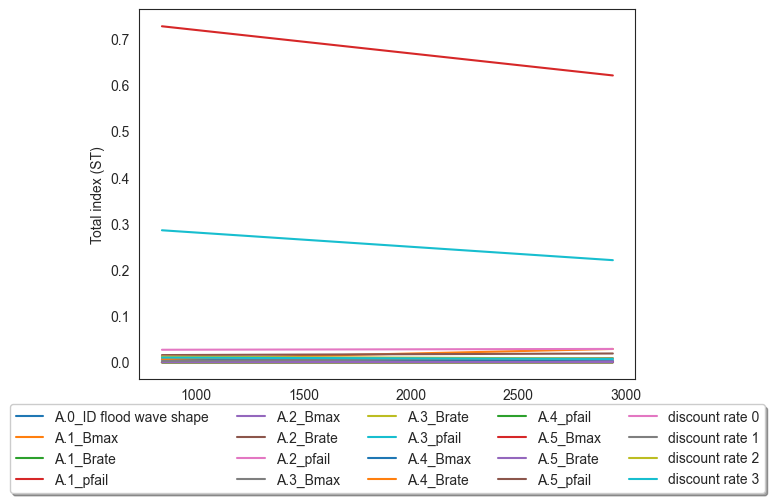

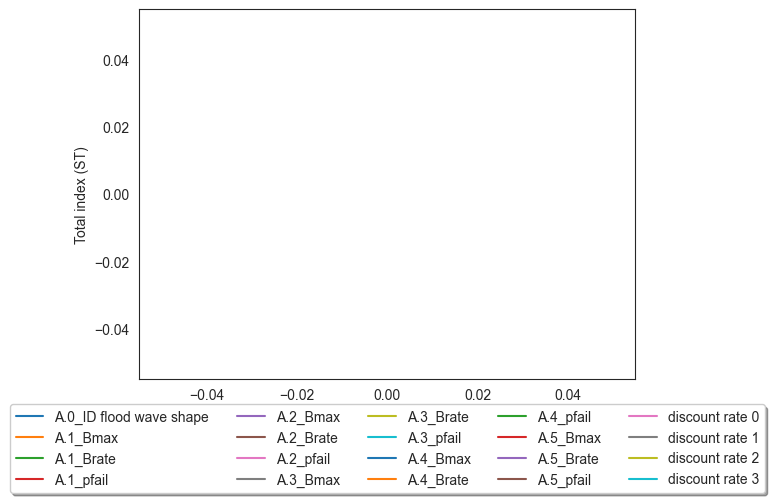

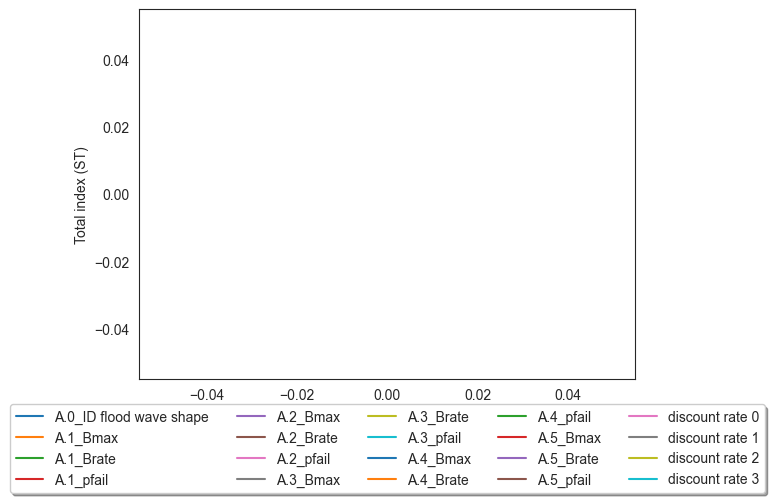

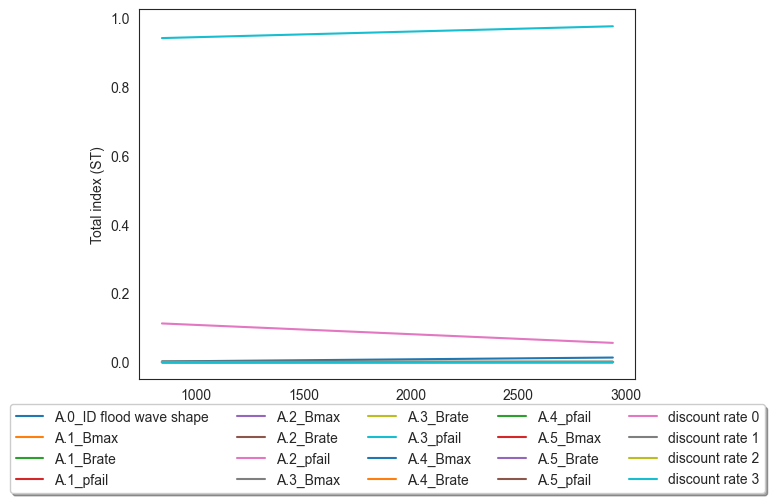

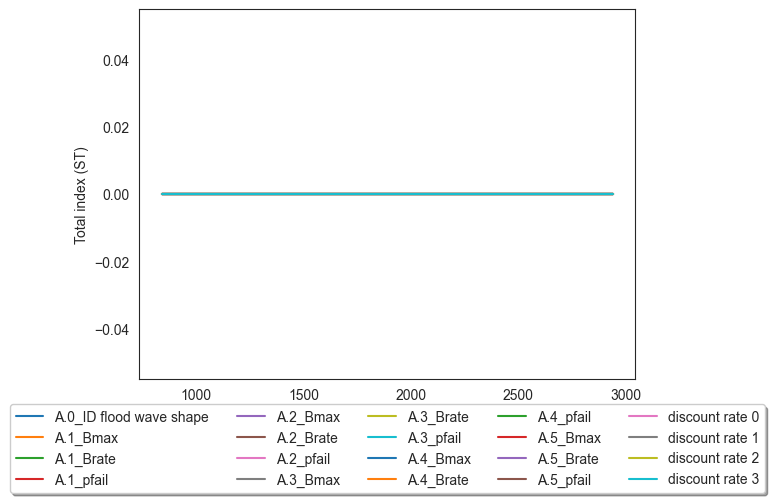

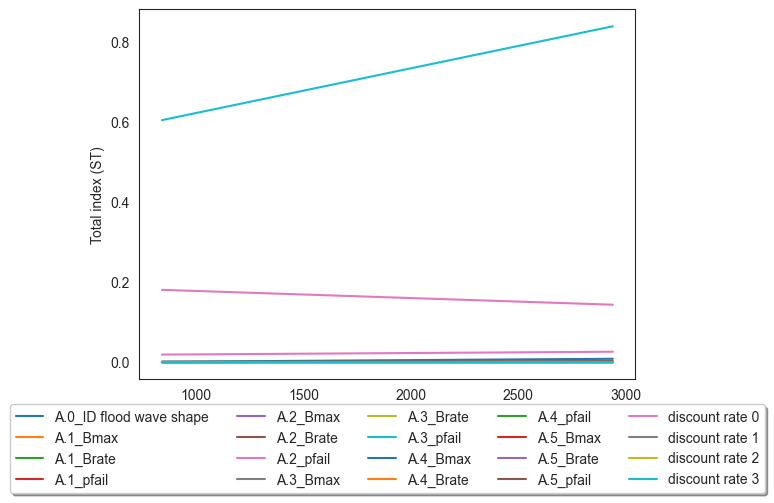

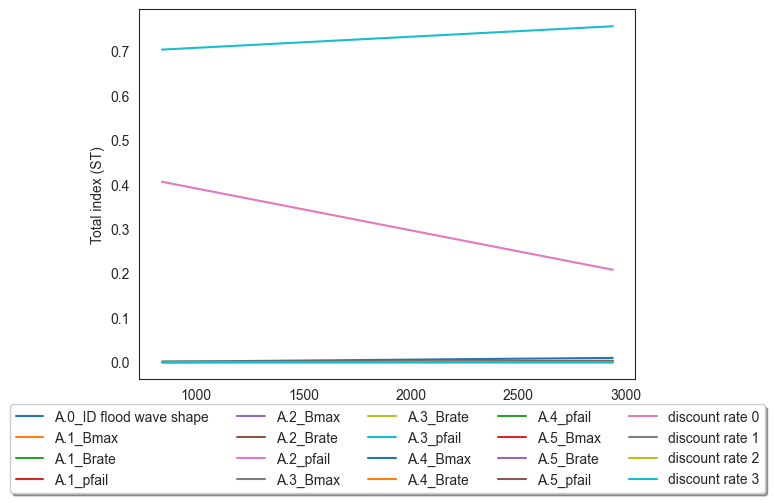

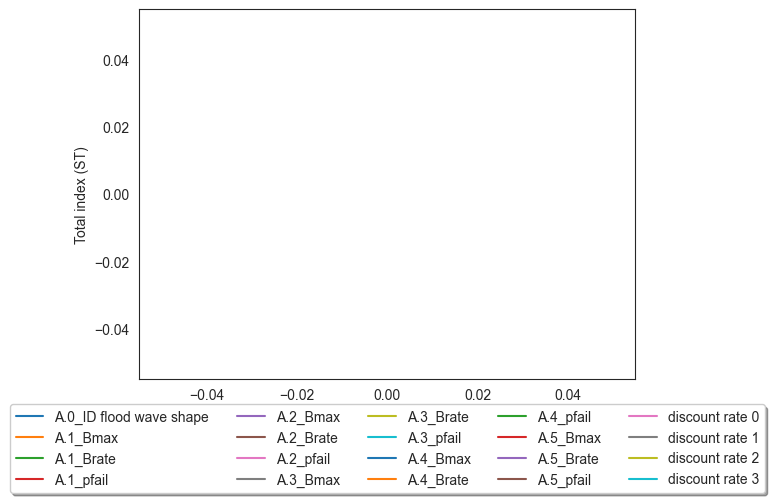

In [7]:
run_sensitivity_analysis("results/run_sobol_base.tar.gz", "results/run_base.tar.gz", 'Base_run_0_policies')
run_sensitivity_analysis("results/run_sobol_policies.tar.gz", "results/run_policies.tar.gz", 'Base_run_10_policies')